# Раз катбуст, два катбуст.

In [1]:
import polars as pl

from catboost import Pool, CatBoostClassifier, cv, sum_models

from sklearn.model_selection import train_test_split

In [2]:
pl.Config(fmt_str_lengths=150)
#pl.Config(tbl_rows=40)

In [3]:
%%time
labeled=pl.read_parquet("labeled_train.parquet").with_columns(pl.col("cat_id").cast(pl.Int16))
labeled

CPU times: user 850 ms, sys: 366 ms, total: 1.22 s
Wall time: 965 ms


hash_id,source_name,attributes,cat_id
str,str,str,i16
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Нет бренда""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность самовы…",10501
"""00002d434ee4516d75b9e99cb4b6b4fb""","""Приемное устройство М1 TDM Уютный дом в монтажную коробку для беспроводного управления нагрузкой 2300Вт дальность 30м SQ1508-0213""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""TDM Electric""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность само…",140
"""000055da1f1a715b7a8c955e4002ade2""","""Духовой шкаф электрический Darina 1U5 BDE 112 708 X5 серебристый (000057011)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4607152046304""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",1397
"""000065493de83bdbacf9093b9e139cbb""","""Коврик для мыши 40*70 см Genshin Impact Desk Mat Zephyr of the Violet Garden 6975213683170""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Genshin Impact""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность са…",3645
"""00006bee8d0f6056ac09833a2cee2b8c""","""Ripo Кабель для интернет-соединения, серый""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Ripo""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза""""…",10421
…,…,…,…
"""fffecb9ea7054ebf85fb66c319dcaebf""","""Конвекторный обогреватель BRAYER BR4881""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""BRAYER""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза…",2473
"""fffeee7c5284337d6578d9f8a9c93b53""","""Водонагреватель накопительный Ariston PRO1 R ABS 50 V SLIM/1,5кВт/50л""","""[{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Ariston""""},{""""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоз…",2433
"""ffff046ddf679fba0eed00bda03eb694""","""Сетевое зарядное устройство, адаптер Borofone BA20A Sharp, USB-A Output, 2.1 A""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4680141226116""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",10354


In [4]:
%%time
labeled1 = labeled.with_columns((pl.col("attributes").str.slice(3,pl.col("attributes").str.len_chars()-5)
                               ).str.split("},{") )
labeled1

CPU times: user 1.79 s, sys: 690 ms, total: 2.48 s
Wall time: 2.48 s


hash_id,source_name,attributes,cat_id
str,str,list[str],i16
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Нет бренда"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":12411,""""attribute_name"""":""""Глубина упаковки"""",""""attribute_measure"""":""""сантиметр"""",""""attribute_value"""":""""18""""""]",10501
"""00002d434ee4516d75b9e99cb4b6b4fb""","""Приемное устройство М1 TDM Уютный дом в монтажную коробку для беспроводного управления нагрузкой 2300Вт дальность 30м SQ1508-0213""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""TDM Electric"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":13522,""""attribute_name"""":""""Максимальная глубина погружения"""",""""attribute_measure"""":""""метр"""",""""attribute_value"""":""""30""""""]",140
"""000055da1f1a715b7a8c955e4002ade2""","""Духовой шкаф электрический Darina 1U5 BDE 112 708 X5 серебристый (000057011)""","[""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4607152046304"""""", """"""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""DARINA"""""", … """"""attribute_id"""":12411,""""attribute_name"""":""""Глубина упаковки"""",""""attribute_measure"""":""""сантиметр"""",""""attribute_value"""":""""59.5""""""]",1397
"""000065493de83bdbacf9093b9e139cbb""","""Коврик для мыши 40*70 см Genshin Impact Desk Mat Zephyr of the Violet Garden 6975213683170""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Genshin Impact"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":13516,""""attribute_name"""":""""Длина в сложенном виде"""",""""attribute_measure"""":""""сантиметр"""",""""attribute_value"""":""""40*70""""""]",3645
"""00006bee8d0f6056ac09833a2cee2b8c""","""Ripo Кабель для интернет-соединения, серый""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Ripo"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":12411,""""attribute_name"""":""""Глубина упаковки"""",""""attribute_measure"""":""""сантиметр"""",""""attribute_value"""":""""17""""""]",10421
…,…,…,…
"""fffecb9ea7054ebf85fb66c319dcaebf""","""Конвекторный обогреватель BRAYER BR4881""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""BRAYER"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":12411,""""attribute_name"""":""""Глубина упаковки"""",""""attribute_measure"""":""""сантиметр"""",""""attribute_value"""":""""82""""""]",2473
"""fffeee7c5284337d6578d9f8a9c93b53""","""Водонагреватель накопительный Ariston PRO1 R ABS 50 V SLIM/1,5кВт/50л""","[""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Ariston"""""", """"""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да"""""", … """"""attribute_id"""":13322,""""attribute_name"""":""""Объем нижнего барабана"""",""""attribute_measure"""":""""литр"""",""""attribute_value"""":""""50""""""]",2433
"""ffff046ddf679fba0eed00bda03eb694""","""Сетевое зарядное устройство, адаптер Borofone BA20A Sharp, USB-A Output, 2.1 A""","[""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4680141226116"""""", """"""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""","""

In [5]:
%%time
labeled1 = labeled1.explode("attributes"
                         ).with_columns(
    pl.col("attributes").str.extract(r"\"attribute_id\"\"\:(\d+?),", 1).cast(pl.Int16).alias("attr_id"),
    pl.col("attributes").str.extract(r"\"\"attribute_name\"\":\"\"(.+?)\"\"", 1).alias("attr_name"),
    pl.col("attributes").str.extract(r"\"\"attribute_value\"\":\"\"(.+?)\"\"", 1).alias("attr_value"),
    pl.col("attributes").str.extract(r"\"\"attribute_measure\"\":\"\"(.+?)\"\"", 1).alias("attr_measure"),
)
labeled1

CPU times: user 19.6 s, sys: 494 ms, total: 20 s
Wall time: 7.22 s


hash_id,source_name,attributes,cat_id,attr_id,attr_name,attr_value,attr_measure
str,str,str,i16,i16,str,str,str
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Нет бренда""""""",10501,8,"""Поставщик""","""Нет бренда""",null
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""""""attribute_id"""":14,""""attribute_name"""":""""Возможность самовывоза"""",""""attribute_value"""":""""Да""""""",10501,14,"""Возможность самовывоза""","""Да""",null
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""""""attribute_id"""":15,""""attribute_name"""":""""Возможность доставки"""",""""attribute_value"""":""""Нет""""""",10501,15,"""Возможность доставки""","""Нет""",null
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""""""attribute_id"""":45,""""attribute_name"""":""""Гарантия"""",""""attribute_value"""":""""Нет""""""",10501,45,"""Гарантия""","""Нет""",null
"""00002c14676b6a5c02d01fd82a92bd50""","""Бойник барабана для стиральной машины Candy, Vestel, Bompani, Whirlpool""","""""""attribute_id"""":49,""""attribute_name"""":""""Страна"""",""""attribute_value"""":""""Турция""""""",10501,49,"""Страна""","""Турция""",null
…,…,…,…,…,…,…,…
"""ffffea9e409dc1d4b33bd24bec4c6111""","""Ноутбук MSI Sword 15 A12UE-487XRU White (9S7-158333-487)""","""""""attribute_id"""":12717,""""attribute_name"""":""""Серия процессора"""",""""attribute_value"""":""""Core i7""""""",1242,12717,"""Серия процессора""","""Core i7""",null
"""ffffea9e409dc1d4b33bd24bec4c6111""","""Ноутбук MSI Sword 15 A12UE-487XRU White (9S7-158333-487)""","""""""attribute_id"""":12720,""""attribute_name"""":""""Тактовая частота процессора, ГГц"""",""""attribute_value"""":""""3.5""""""",1242,12720,"""Тактовая частота процессора, ГГц""","""3.5""",null
"""ffffea9e409dc1d4b33bd24bec4c6111""","""Ноутбук MSI Sword 15 A12UE-487XRU White (9S7-158333-487)""","""""""attribute_id"""":12721,""""attribute_name"""":""""Тип графического адаптера"""",""""attribute_value"""":""""дискретный""""""",1242,12721,"""Тип графического адаптера""","""дискретный""",null


In [6]:
%%time
pl.Config(tbl_rows=100)
attrs = labeled1.group_by("attr_id"
                ).agg(pl.col("cat_id").unique().alias("cats list"),
                      pl.col("cat_id").n_unique().alias("cats count"),
                      pl.col("attr_name").unique(),
                      pl.col("attr_value").unique().alias("values list"),
                      pl.col("attr_value").n_unique().alias("values count"),
                      pl.col("attr_measure").unique().alias("measures list"),
                      pl.col("attr_measure").n_unique().alias("measures count"),
                      pl.col("hash_id").n_unique().alias("items count"),
                     ).sort("attr_id")
attrs

CPU times: user 3.85 s, sys: 556 ms, total: 4.41 s
Wall time: 1.27 s


attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
null,"[1, 10, … 31435]",360,[null],[null],1,[null],1,111618
1,"[10, 118, … 31419]",122,"[""Масса""]","[""385"", ""1100"", … ""45""]",291,"[""грамм"", ""килограмм"", ""тонна""]",3,2955
2,"[383, 420, … 31435]",82,"[""Объем""]","[""50"", ""60"", … ""100""]",165,"[""гб"", ""миллилитр"", … null]",4,4784
3,"[132, 383, … 31406]",22,"[""Количество""]","[""250-"", ""1"", … ""12""]",23,"[""секция"", ""лист"", … ""упаковка""]",9,127
4,"[1, 132, … 31408]",49,"[""Процентное содержание""]","[""60"", ""99.998"", … ""5""]",54,"[""процент""]",1,524
5,"[10, 118, … 31435]",168,"[""Длина/площадь""]","[""19.5"", ""112"", … ""8,5""]",499,"[""дюйм"", ""километр"", ""дециметр""]",3,15432
6,"[1, 10, … 31435]",538,"[""Штрихкод""]","[""8012950001008"", ""110076251258"", … ""6958265183478""]",152151,[null],1,197635
8,"[1, 2, … 31435]",769,"[""Поставщик""]","[""C3 SOLUTIONS"", ""BS Mi"", … ""ПКФ ОЗОН""]",15737,[null],1,596265
11,"[1, 120, … 30947]",60,"[""Измерение информации""]","[""1x32"", ""1480"", … ""2.4""]",95,"[""бит"", ""терабайт"", … ""мегабайт""]",4,2114


In [7]:
#attrs.write_parquet("attrs.parquet")

In [8]:
%%time
#TD для категорий с вложениями надо переделать
pl.Config(tbl_rows=20)
catsattrs = labeled1.group_by("cat_id"
                ).agg(pl.col("attr_id").unique().alias("attrs list"),
                      pl.col("attr_id").n_unique().alias("attrs count"),
                      pl.col("attr_name").unique().alias("attr names list"),
                      #pl.col("attr_value").unique().alias("values list"),
                      #pl.col("attr_value").n_unique().alias("values count"),
                      #pl.col("attr_measure").unique().alias("measures list"),
                      #pl.col("attr_measure").n_unique().alias("measures count"),
                      pl.col("hash_id").n_unique().alias("items count"),
                     ).sort("cat_id", descending=True)
catsattrs

CPU times: user 1.26 s, sys: 147 ms, total: 1.41 s
Wall time: 395 ms


cat_id,attrs list,attrs count,attr names list,items count
i16,list[i16],u32,list[str],u32
31435,"[null, 2, … 13386]",32,"[""Возможность доставки"", ""Глубина упаковки"", … ""Высота упаковки""]",187
31434,"[null, 5, … 13456]",34,"[""Название"", ""Поставщик"", … ""Маркетинговый цвет""]",252
31423,"[null, 5, … 13569]",89,"[""Комплект поставки"", ""Разъемы USB"", … ""Количество вентиляторов""]",7390
31422,"[null, 5, … 14103]",63,"[""Reviewsrating"", ""Диаметр воронки"", … ""Размер сварочной насадки""]",1788
31419,"[null, 1, … 13516]",53,"[""Индекс цветопередачи"", ""Вес упаковки, в килограммах"", … ""Модель""]",9984
31418,"[5, 6, … 12411]",25,"[""Cashback"", ""Название"", … ""Глубина упаковки""]",95
31408,"[null, 1, … 13925]",77,"[""Штрихкод"", ""Поставщик"", … ""Ширина упаковки, в сантиметрах""]",1122
31406,"[null, 1, … 13915]",102,"[""Гарантия на акб"", ""Модель"", … ""Терка/шинковка (двусторонний диск)""]",19210
31405,"[null, 1, … 14044]",121,"[""Возможность самовывоза"", ""Объем сливного бака"", … ""Наименование модели""]",7158


# 460

In [9]:
attrs.filter(pl.col("cats list").list.contains(460))

attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
null,"[1, 10, … 31435]",360,[null],[null],1,[null],1,111618
1,"[10, 118, … 31419]",122,"[""Масса""]","[""385"", ""1100"", … ""45""]",291,"[""грамм"", ""килограмм"", ""тонна""]",3,2955
3,"[132, 383, … 31406]",22,"[""Количество""]","[""250-"", ""1"", … ""12""]",23,"[""секция"", ""лист"", … ""упаковка""]",9,127
4,"[1, 132, … 31408]",49,"[""Процентное содержание""]","[""60"", ""99.998"", … ""5""]",54,"[""процент""]",1,524
5,"[10, 118, … 31435]",168,"[""Длина/площадь""]","[""19.5"", ""112"", … ""8,5""]",499,"[""дюйм"", ""километр"", ""дециметр""]",3,15432
6,"[1, 10, … 31435]",538,"[""Штрихкод""]","[""8012950001008"", ""110076251258"", … ""6958265183478""]",152151,[null],1,197635
8,"[1, 2, … 31435]",769,"[""Поставщик""]","[""C3 SOLUTIONS"", ""BS Mi"", … ""ПКФ ОЗОН""]",15737,[null],1,596265
12,"[1, 10, … 31423]",227,"[""Дата, время, срок""]","[""270"", ""2913"", … ""115*""]",702,"[""час"", ""лет"", … ""минута""]",7,5210
45,"[1, 2, … 31435]",583,"[""Гарантия""]","[""1"", ""12"", … ""2017-2021""]",25,"[null, ""год"", … ""лет""]",7,328533


In [10]:
attrs460 = labeled1.filter(pl.col("cat_id")==460
                         ).group_by("attr_id"
                ).agg(pl.col("cat_id").unique().alias("cats list"),
                      pl.col("cat_id").n_unique().alias("cats count"),
                      pl.col("attr_name").unique(),
                      pl.col("attr_value").unique().alias("values list"),
                      pl.col("attr_value").n_unique().alias("values count"),
                      pl.col("attr_measure").unique().alias("measures list"),
                      pl.col("attr_measure").n_unique().alias("measures count"),
                      pl.col("hash_id").n_unique().alias("items count"),
                     ).sort("attr_id")
attrs460

attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
null,[460],1,[null],[null],1,[null],1,332
1,[460],1,"[""Масса""]","[""02.02.1960"", ""1986"", … ""1949""]",9,"[""грамм""]",1,9
3,[460],1,"[""Количество""]","[""3""]",1,"[""лист""]",1,1
4,[460],1,"[""Процентное содержание""]","[""100""]",1,"[""процент""]",1,1
5,[460],1,"[""Длина/площадь""]","[""1970-1974"", ""3x12"", … ""8x12""]",13,"[""дюйм""]",1,29
6,[460],1,"[""Штрихкод""]","[""0036172006922"", ""5013929089105"", … ""4607031757482""]",2624,[null],1,2629
8,[460],1,"[""Поставщик""]","[""Carus"", ""Parlophone"", … ""DreaMusic""]",537,[null],1,2717
12,[460],1,"[""Дата, время, срок""]","[""10"", ""7""]",2,"[""лет""]",1,3
45,[460],1,"[""Гарантия""]","[""1980"", ""1976"", ""1812""]",3,"[""года""]",1,4


In [11]:
attrs460.filter(pl.col("items count")<10)

attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
1,[460],1,"[""Масса""]","[""02.02.1960"", ""1986"", … ""1949""]",9,"[""грамм""]",1,9
3,[460],1,"[""Количество""]","[""3""]",1,"[""лист""]",1,1
4,[460],1,"[""Процентное содержание""]","[""100""]",1,"[""процент""]",1,1
12,[460],1,"[""Дата, время, срок""]","[""10"", ""7""]",2,"[""лет""]",1,3
45,[460],1,"[""Гарантия""]","[""1980"", ""1976"", ""1812""]",3,"[""года""]",1,4
670,[460],1,"[""Цветовая температура""]","[""281"", ""24"", ""25""]",3,"[""k""]",1,3
1111,[460],1,"[""Ресурс черного картриджа (a4)""]","[""6""]",1,"[""стр""]",1,1
1303,[460],1,"[""Тип упаковки""]","[""DVD Box""]",1,[null],1,1
1377,[460],1,"[""Насадка-спонж""]","[""100""]",1,"[""шт.""]",1,1


In [12]:
idatrlist460_10 = attrs460.filter(pl.col("items count")<=10)["attr_id"].to_list()
idatrlist460_10

[1, 3, 4, 12, 45, 670, 1111, 1303, 1377, 2585, 12680]

In [13]:
labeled1.filter(pl.col("cat_id")==460
                         ).filter(pl.col("attr_id").is_in(idatrlist460_10))

hash_id,source_name,attributes,cat_id,attr_id,attr_name,attr_value,attr_measure
str,str,str,i16,i16,str,str,str
"""04adaa3aeb71bb02e6e3967a5fc24741""","""Уэллс Г. """"Машина времени"""" Радиопостановка.1990 г. В ролях: Л.Макарова, Г.Богачев, В.Яковле""","""""attribute_id"""":1,""""attribute_name"""":""""Масса"""",""""attribute_measure"""":""""грамм"""",""""attribute_value"""":""""1990""""""",460,1,"""Масса""","""1990""","""грамм"""
"""053597d53a1a5d019b896c572b6383b6""","""Шено П. """"Будьте здоровы!"""" Радиокомпозиция спектакля театра им.Е.Вахтангова. 1986 г. Исполн""","""""attribute_id"""":1,""""attribute_name"""":""""Масса"""",""""attribute_measure"""":""""грамм"""",""""attribute_value"""":""""1986""""""",460,1,"""Масса""","""1986""","""грамм"""
"""079475c8eb55b4b518e1f899f282c068""","""Horowitz Vladimir Mozart: Piano Sonatas K.281, K.330 & K.333 Rondo K.485 Adagio K.540""","""""""attribute_id"""":670,""""attribute_name"""":""""Цветовая температура"""",""""attribute_measure"""":""""k"""",""""attribute_value"""":""""281""""""",460,670,"""Цветовая температура""","""281""","""k"""
"""11c7cdb090bc85906c65cb11fa07b03f""","""Bruno Mars 24K Magic (Translucent Green With Opaque Spring Green & Yellow Splatter) (LP)""","""""""attribute_id"""":670,""""attribute_name"""":""""Цветовая температура"""",""""attribute_measure"""":""""k"""",""""attribute_value"""":""""24""""""",460,670,"""Цветовая температура""","""24""","""k"""
"""1577a1877f4e5fde5df3926bf448ca0b""","""Детям от 3 до 7 лет. Носов Н.Бобик в гостях у Барбоса и др. истории. Mp3 Ардис""","""""""attribute_id"""":12,""""attribute_name"""":""""Дата, время, срок"""",""""attribute_measure"""":""""лет"""",""""attribute_value"""":""""7""""""",460,12,"""Дата, время, срок""","""7""","""лет"""
"""179583deaa1c7cbd37fb3f3dcfa44521""","""Дюма А. """"Сердца и шпаги"""" . Радиоспектакль по роману """"Три мушкетеры"""".1991 г. В ролях: А..Ба""","""""attribute_id"""":1,""""attribute_name"""":""""Масса"""",""""attribute_measure"""":""""грамм"""",""""attribute_value"""":"""".1991""""""",460,1,"""Масса""",""".1991""","""грамм"""
"""2d1b52320221c8b8e66c7776f4a47623""","""Wilhelm Kempff: Italian Suite, Op. 68 - Piano Sonata, Op. 47 - Transcriptions""","""""""attribute_id"""":1303,""""attribute_name"""":""""Тип упаковки"""",""""attribute_value"""":""""DVD Box""""""",460,1303,"""Тип упаковки""","""DVD Box""",null
"""2d1b52320221c8b8e66c7776f4a47623""","""Wilhelm Kempff: Italian Suite, Op. 68 - Piano Sonata, Op. 47 - Transcriptions""","""""""attribute_id"""":2585,""""attribute_name"""":""""Разрешение"""",""""attribute_value"""":""""1280x720""""""",460,2585,"""Разрешение""","""1280x720""",null
"""2d1b52320221c8b8e66c7776f4a47623""","""Wilhelm Kempff: Italian Suite, Op. 68 - Piano Sonata, Op. 47 - Transcriptions""","""""""attribute_id"""":12680,""""attribute_name"""":""""Издание"""",""""attribute_value"""":""""упрощенное""""""",460,12680,"""Издание""","""упрощенное""",null


In [14]:
#https://www.ozon.ru/product/ace-of-base-flowers-vinilovaya-plastinka-lp-140g-clear-vinyl-804248500/
#разметка по аттрибутам подорвала доверие к себе

In [15]:
idatrlist460 = attrs460.filter(pl.col("items count")>10)["attr_id"].to_list()[1:]
idatrlist460

[5,
 6,
 8,
 49,
 56,
 61,
 594,
 597,
 598,
 604,
 2952,
 2955,
 12335,
 12336,
 12343,
 12344]

In [16]:
idatrlist460.remove(12335)
idatrlist460.remove(12336)
idatrlist460.remove(12343)
idatrlist460.remove(12344)
idatrlist460

[5, 6, 8, 49, 56, 61, 594, 597, 598, 604, 2952, 2955]

In [17]:
labeled1.filter(pl.col("cat_id")==460
               ).filter(pl.col("attr_id").is_in(idatrlist460)
                       ).pivot("attr_id", index="source_name", values="attr_value", aggregate_function="first"
                              )

source_name,5,6,8,49,594,597,598,604,2952,2955,56,61
str,str,str,str,str,str,str,str,str,str,str,str,str
"""Liam Gallagher /All You're Dreaming Of…(Limited Edition)(Coloured Vinyl)(12"""" Vinyl Single)""","""12""","""190295148140""","""Warner Music""","""Евросоюз""","""Brit Pop""","""Carton Sleeve""","""SL""","""2020""","""Warner Music""","""лимитированное""",null,null
"""OST John Wick Chapter 4 Joel J. Richard & Tyler Bates Orange, Limited (2LP)""",null,"""0780163638622""","""Lakeshore Records""","""Евросоюз""","""Soundtrack""",null,"""LP""",null,null,"""альбом""","""John Wick: Chapter 4 (joel J. Richard & Tyler Bates)""",null
"""Михаил Плетнёв - Лист: Соната си минор, Мефисто-вальс, Венгерская рапсодия и т.д.""",null,"""4607167791183""","""Международная книга - Музыка""","""Россия""","""Classic""","""Jewel Case""",null,null,"""Международная книга - Музыка""",null,null,null
"""Steve Salas: The Sun And The Earth """"The Essential Stevie Salas"""" Vol. 1 (cd)""",null,"""5030559104022""","""Arbor Records Ltd.""",null,null,null,null,null,null,null,"""2 CD""",null
"""Handel: Music for Cannons - Graham O'Reilly, Academie de Ste Cecile, Ensemble William Byrd""",null,"""0742495307225""","""L'empreinte Digitale""",null,"""Classic""","""Jewel case""",null,null,"""L'empreinte Digitale""",null,"""1 CD""",null
"""George Crumb : Une Petite Suite pour No;l - Richard Wernick : Sonate pour Piano """"reflectio""",null,"""0090404900327""","""Bridge""",null,null,null,null,null,null,null,"""1 CD""",null
"""Виниловая пластинка Padang Moonrise (The Birth Of The Modern Industry 1955-69)""",null,null,"""Soundway""",null,null,null,null,null,null,null,"""Various Artists Padang Moonrise (The Birth Of The Modern Indonesian Recording Industry ? 1955-69)""",null
"""Paloma Faith / Do You Want The Truth Or Something Beautiful? (Coloured Vinyl)(LP)""",null,"""190759592311""","""Sony Music""","""Евросоюз""","""Funk; Soul; Pop Rock""","""Carton Sleeve; Coloured Vinyl""","""LP""","""2019""","""Sony Music""","""переиздание""",null,null
"""Whitesnake: Forevermore (Limited Edition Box-Set) (2LP + CD + DVD + Lithographie)""",null,"""8024391050965""","""Frontiers Records S.R.L.""",null,null,null,null,null,null,null,"""4 (2 LP + 1 CD + 1 DVD)""",null


In [18]:
#Какое качество даст катбуст на атрибутах без названий?

# КатБуст

In [19]:
%%time
data=labeled1.with_columns( pl.col("attr_id").cast(pl.String)
                     ).group_by("hash_id","cat_id","source_name"
                 ).agg(pl.col("attr_id").unique()
                      ).with_columns( pl.col("attr_id").list.join(separator=" ")
                                    ).join(
    labeled1.filter(pl.col("attr_id").is_in(idatrlist460)
                           ).pivot("attr_id", index="hash_id", values="attr_value", aggregate_function="first"
                                  ),
    how="left",
    on="hash_id"
)
data

CPU times: user 5.63 s, sys: 1.82 s, total: 7.45 s
Wall time: 3.18 s


hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,594,597,598,604,2952,2955
str,i16,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2b5bdde7ca24baf925ad17e6201106ec""",1291,"""Клавиатура Acer OKW020 черный USB slim""","""""",null,null,null,null,null,null,null,null,null,null,null,null
"""eebd1b8e000e4cb8da48a959a4b13350""",10501,"""Манжета (уплотнительная резина) люка для стиральной машины Indesit, Ariston, C00118008""","""96 6316 61 97 12335 12338 8 56""","""Indesit""",null,null,"""серый""","""C00118008""",null,null,null,null,null,null,null
"""57e56e5e512083f31294d78f6267e850""",1030,"""Системный блок LogicByte Intel Core i5 14400F/64 ГБ/SSD 500 GB/RX 6600 8GB/600w""","""12335 104 2639 56 8""","""LogicByte""",null,null,null,"""L8172""",null,null,null,null,null,null,null
"""69ce2c929f2362767df0f61e3ee5fe4c""",3226,"""Сумка для ноутбука нетбука макбука планшета 13 13,3 13.3 14 14.1 14,1 дюймов Ultra 14 BL, желтая""","""""",null,null,null,null,null,null,null,null,null,null,null,null
"""d489bd1fc55694c7d35d222b5e0511b7""",1370,"""Аккумулятор для HP 15-dw0045ur ноутбука акб""","""11740 52 12335 12405 12406 12407 12411 8 15 49 482 14 45 11742""","""Нет бренда""","""Россия""",null,null,null,null,null,null,null,null,null,null
"""7dfa95f4cd45f134ff6c98db5163df65""",1030,"""Системный блок BonusPK 53776026""","""8 12335 6""","""BonusPK""",null,"""110166329584""",null,null,null,null,null,null,null,null,null
"""c335988652b3d6d0fda32fc1576accb2""",1244,"""Планшет HUAWEI MatePad 10.4"""" SE Wi-Fi 32 ГБ, черный""","""""",null,null,null,null,null,null,null,null,null,null,null,null
"""a45058554ac7392e48f9ce07b9af95db""",1030,"""Системный блок StarsComp 2058067""","""10029 2767 8 3321 6316 2905 6 12685 12717 12335 97 17""","""StarsComp""",null,"""110161025979""",null,null,null,null,null,null,null,null,null
"""cc80a78c169d5f294980db15840599fc""",1244,"""Планшет Jumper Ezpad i7 12"""" 8/512GB Gray Wi-Fi""","""104 12335 12336 8 2901 5 56""","""Jumper""",null,null,null,"""Ezpad i7""","""12""",null,null,null,null,null,null


In [20]:
data0 = data.filter(pl.col("attr_id")!=""  #TD для товаров без атрибутов нужна будет отдельная доработка
                  ).with_columns(pl.col("cat_id")==460
                  ).with_columns(pl.col("cat_id").cast(pl.Int8)
                                ).fill_null("---")
data0

hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,594,597,598,604,2952,2955
str,i8,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""eebd1b8e000e4cb8da48a959a4b13350""",0,"""Манжета (уплотнительная резина) люка для стиральной машины Indesit, Ariston, C00118008""","""96 6316 61 97 12335 12338 8 56""","""Indesit""","""---""","""---""","""серый""","""C00118008""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""57e56e5e512083f31294d78f6267e850""",0,"""Системный блок LogicByte Intel Core i5 14400F/64 ГБ/SSD 500 GB/RX 6600 8GB/600w""","""12335 104 2639 56 8""","""LogicByte""","""---""","""---""","""---""","""L8172""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""d489bd1fc55694c7d35d222b5e0511b7""",0,"""Аккумулятор для HP 15-dw0045ur ноутбука акб""","""11740 52 12335 12405 12406 12407 12411 8 15 49 482 14 45 11742""","""Нет бренда""","""Россия""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""7dfa95f4cd45f134ff6c98db5163df65""",0,"""Системный блок BonusPK 53776026""","""8 12335 6""","""BonusPK""","""---""","""110166329584""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""a45058554ac7392e48f9ce07b9af95db""",0,"""Системный блок StarsComp 2058067""","""10029 2767 8 3321 6316 2905 6 12685 12717 12335 97 17""","""StarsComp""","""---""","""110161025979""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""cc80a78c169d5f294980db15840599fc""",0,"""Планшет Jumper Ezpad i7 12"""" 8/512GB Gray Wi-Fi""","""104 12335 12336 8 2901 5 56""","""Jumper""","""---""","""---""","""---""","""Ezpad i7""","""12""","""---""","""---""","""---""","""---""","""---""","""---"""
"""0645707863925731aa191397c941b616""",0,"""Посудомоечная машина Leran FDW 60-1485 CW белый""","""204 8 56 3933 12337 55 61 6 3321 10029 12335 1096 12338""","""Leran""","""---""","""4670220100772""","""белый""","""FDW 60-1485 CW""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""90029acea17ce156f25f51d9f9f8c986""",0,"""Чехол-подставка MyPads для iPad mini 4 7.9 (2015) - A1538, A1550 на пластиковой основе кожаный поворотный роторный оборотный с трансформацией в подста…","""49 482 11742 12407 12335 11740 12405 45 14 8 15 61 12411 52 12406""","""MyPads""","""Россия""","""---""","""оранжевый""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""
"""bd1f0542ebe50b74d0e1eee0e8194d6b""",0,"""Системный блок ЮКомс Core i9-13900KF/RTX 3090 Ti 24GB/ssd 480gb/32Gb/win 10 pro""","""8 12717 2928 2639 12335 17 3321 97 104 2767""","""ЮКомс""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""


## Вариант text12345 i5

In [21]:
y=data0[["cat_id"]].to_pandas()
#X=data0.drop("cat_id","source_name","hash_id")
X=data0[["attr_id"]].to_pandas()
cols1=list(X.columns)
X

,attr_id
0,96 6316 61 97 12335 12338 8 56
1,12335 104 2639 56 8
2,11740 52 12335 12405 12406 12407 12411 8 15 49...
3,8 12335 6
4,10029 2767 8 3321 6316 2905 6 12685 12717 1233...
...,...
604929,45 11742 482 49 52 12405 15 12335 12407 6 131 ...
604930,8 13840 12336 97 96 10029 12335 12345
604931,12407 12411 482 12335 12405 45 12406 49 15 8 5...
604932,12335 6 12336 8 97 104 10029


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)

In [23]:
cb1=CatBoostClassifier(
    iterations=5,
    text_features=["attr_id"],
    custom_metric=["Accuracy","Precision","F1"],
    eval_metric="F1",
    random_seed=0,
)
cb1.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb1.save_model("cb1_12345.cbm")
cb1.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 133ms	remaining: 532ms
4:	learn: 0.8427673	test: 0.8031000	best: 0.8031000 (4)	total: 457ms	remaining: 0us

bestTest = 0.8031000242
bestIteration = 4



,Feature Id,Importances
0,attr_id,100.0


## Вариант cat 1,2,3,4,5 i20

In [24]:
y=data0[["cat_id"]].to_pandas()
X=data0.drop("cat_id","source_name","hash_id","attr_id").fill_null("---").to_pandas()
cols2=list(X.columns)

#X=data0[["attr_id"]].to_pandas()
X

,8,49,6,61,56,5,594,597,598,604,2952,2955
0,Indesit,---,---,серый,C00118008,---,---,---,---,---,---,---
1,LogicByte,---,---,---,L8172,---,---,---,---,---,---,---
2,Нет бренда,Россия,---,---,---,---,---,---,---,---,---,---
3,BonusPK,---,110166329584,---,---,---,---,---,---,---,---,---
4,StarsComp,---,110161025979,---,---,---,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...
604929,RageX,Китай,2001344710622,---,---,---,---,---,---,---,---,---
604930,NoBrand,---,---,---,---,---,---,---,---,---,---,---
604931,TopSpare,Россия,---,---,---,---,---,---,---,---,---,---
604932,QNAP,---,4713213512043,---,---,---,---,---,---,---,---,---


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)

In [26]:
cb2=CatBoostClassifier(
    iterations=20,
    #text_features=list(X.columns),
    cat_features=list(X.columns),
    #cat_features=[8],
    custom_metric=["Accuracy","Precision","F1"],
    eval_metric="F1",
)
cb2.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb2.save_model("cb2_1-2-3.cbm")
cb2.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.478677
0:	learn: 0.6697674	test: 0.6436479	best: 0.6436479 (0)	total: 92.4ms	remaining: 1.75s
19:	learn: 0.9604520	test: 0.9600666	best: 0.9602663 (11)	total: 587ms	remaining: 0us

bestTest = 0.9602662783
bestIteration = 11

Shrink model to first 12 iterations.


,Feature Id,Importances
0,56,38.591046
1,8,17.840309
2,597,16.262126
3,594,11.023298
4,604,5.467883
5,49,3.116948
6,598,2.554703
7,2952,2.507603
8,5,2.238136
9,2955,0.397947


## Вариант name text i20

In [27]:
y=data0[["cat_id"]].to_pandas()
#X=data0.drop("cat_id","source_name","hash_id","attr_id").fill_null("---").to_pandas()
X=data0[["source_name"]].to_pandas()
cols3=list(X.columns)
X

,source_name
0,Манжета (уплотнительная резина) люка для стира...
1,Системный блок LogicByte Intel Core i5 14400F/...
2,Аккумулятор для HP 15-dw0045ur ноутбука акб
3,Системный блок BonusPK 53776026
4,Системный блок StarsComp 2058067
...,...
604929,Аккумулятор AS07B31 для ноутбука Acer Aspire 5...
604930,Лапка для швейной машины подрубочная 4 и 6 мм
604931,"Клавиатура для HP ProBook 430, 430 G1 (727765-..."
604932,"Оперативная память QNAP (RAM-4GDR4A0-UD-2400),..."


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)

In [29]:
cb3=CatBoostClassifier(
    iterations=20,
    text_features=list(X.columns),
    custom_metric=["Accuracy","Precision","F1"],
    eval_metric="F1",
)
cb3.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb3.save_model("cb3name.cbm")
cb3.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.478677


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 109ms	remaining: 2.07s
19:	learn: 0.7483871	test: 0.7591204	best: 0.7627119 (18)	total: 2.5s	remaining: 0us

bestTest = 0.7627118644
bestIteration = 18

Shrink model to first 19 iterations.


,Feature Id,Importances
0,source_name,100.0


In [30]:
data1 = data0.to_pandas()
data1

,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,594,597,598,604,2952,2955
0,eebd1b8e000e4cb8da48a959a4b13350,0,Манжета (уплотнительная резина) люка для стира...,96 6316 61 97 12335 12338 8 56,Indesit,---,---,серый,C00118008,---,---,---,---,---,---,---
1,57e56e5e512083f31294d78f6267e850,0,Системный блок LogicByte Intel Core i5 14400F/...,12335 104 2639 56 8,LogicByte,---,---,---,L8172,---,---,---,---,---,---,---
2,d489bd1fc55694c7d35d222b5e0511b7,0,Аккумулятор для HP 15-dw0045ur ноутбука акб,11740 52 12335 12405 12406 12407 12411 8 15 49...,Нет бренда,Россия,---,---,---,---,---,---,---,---,---,---
3,7dfa95f4cd45f134ff6c98db5163df65,0,Системный блок BonusPK 53776026,8 12335 6,BonusPK,---,110166329584,---,---,---,---,---,---,---,---,---
4,a45058554ac7392e48f9ce07b9af95db,0,Системный блок StarsComp 2058067,10029 2767 8 3321 6316 2905 6 12685 12717 1233...,StarsComp,---,110161025979,---,---,---,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604929,d846a436a9baa4bf09f5a1d2e35b1b6e,0,Аккумулятор AS07B31 для ноутбука Acer Aspire 5...,45 11742 482 49 52 12405 15 12335 12407 6 131 ...,RageX,Китай,2001344710622,---,---,---,---,---,---,---,---,---
604930,b81ed1139c8d9f32a58aa18b82ae48e7,0,Лапка для швейной машины подрубочная 4 и 6 мм,8 13840 12336 97 96 10029 12335 12345,NoBrand,---,---,---,---,---,---,---,---,---,---,---
604931,290f7106294ea204b3b3045a9843bb93,0,"Клавиатура для HP ProBook 430, 430 G1 (727765-...",12407 12411 482 12335 12405 45 12406 49 15 8 5...,TopSpare,Россия,---,---,---,---,---,---,---,---,---,---
604932,92702b5f8f69045b6aa2d2c1b9e28c0f,0,"Оперативная память QNAP (RAM-4GDR4A0-UD-2400),...",12335 6 12336 8 97 104 10029,QNAP,---,4713213512043,---,---,---,---,---,---,---,---,---


In [31]:
data1["p1"]=cb1.predict(data1[cols1])
data1["p2"]=cb2.predict(data1[cols2])
data1["p3"]=cb3.predict(data1[cols3])
data1["p_1"]=cb1.predict_proba(data1[cols1])[:,1]
data1["p_2"]=cb2.predict_proba(data1[cols2])[:,1]
data1["p_3"]=cb3.predict_proba(data1[cols3])[:,1]
# Можно сверху этого посадить ещё один катбуст, а сбоку приклеить ЛЛМ, но сегодня этого не будет


data1["p123"]=data1["p1"]+data1["p2"]+data1["p3"]
data1["p_123"]=data1["p_1"]+data1["p_2"]+data1["p_3"]
data1

,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
0,eebd1b8e000e4cb8da48a959a4b13350,0,Манжета (уплотнительная резина) люка для стира...,96 6316 61 97 12335 12338 8 56,Indesit,---,---,серый,C00118008,---,...,---,---,0,0,0,0.034607,0.001588,0.000169,0,0.036365
1,57e56e5e512083f31294d78f6267e850,0,Системный блок LogicByte Intel Core i5 14400F/...,12335 104 2639 56 8,LogicByte,---,---,---,L8172,---,...,---,---,0,0,0,0.034607,0.001588,0.000323,0,0.036519
2,d489bd1fc55694c7d35d222b5e0511b7,0,Аккумулятор для HP 15-dw0045ur ноутбука акб,11740 52 12335 12405 12406 12407 12411 8 15 49...,Нет бренда,Россия,---,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000169,0,0.036365
3,7dfa95f4cd45f134ff6c98db5163df65,0,Системный блок BonusPK 53776026,8 12335 6,BonusPK,---,110166329584,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000323,0,0.036519
4,a45058554ac7392e48f9ce07b9af95db,0,Системный блок StarsComp 2058067,10029 2767 8 3321 6316 2905 6 12685 12717 1233...,StarsComp,---,110161025979,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000323,0,0.036519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604929,d846a436a9baa4bf09f5a1d2e35b1b6e,0,Аккумулятор AS07B31 для ноутбука Acer Aspire 5...,45 11742 482 49 52 12405 15 12335 12407 6 131 ...,RageX,Китай,2001344710622,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000169,0,0.036365
604930,b81ed1139c8d9f32a58aa18b82ae48e7,0,Лапка для швейной машины подрубочная 4 и 6 мм,8 13840 12336 97 96 10029 12335 12345,NoBrand,---,---,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000169,0,0.036365
604931,290f7106294ea204b3b3045a9843bb93,0,"Клавиатура для HP ProBook 430, 430 G1 (727765-...",12407 12411 482 12335 12405 45 12406 49 15 8 5...,TopSpare,Россия,---,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000169,0,0.036365
604932,92702b5f8f69045b6aa2d2c1b9e28c0f,0,"Оперативная память QNAP (RAM-4GDR4A0-UD-2400),...",12335 6 12336 8 97 104 10029,QNAP,---,4713213512043,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.000323,0,0.036519


<Axes: >

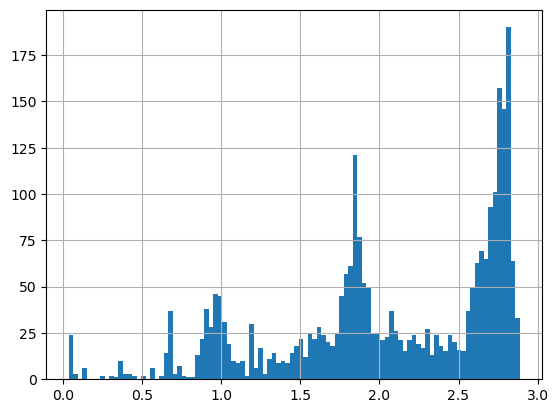

In [32]:
data1[data1["cat_id"]==1]["p_123"].hist(bins=100)

<Axes: >

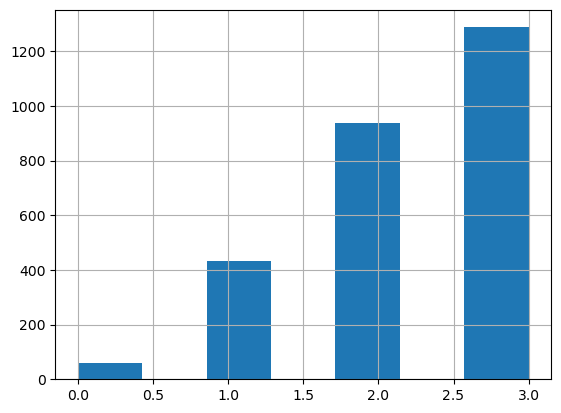

In [33]:
data1[data1["cat_id"]==1]["p123"].hist(bins=7)

/tmp/ipykernel_58783/469442806.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]>0]["p123"].hist(bins=3)


<Axes: >

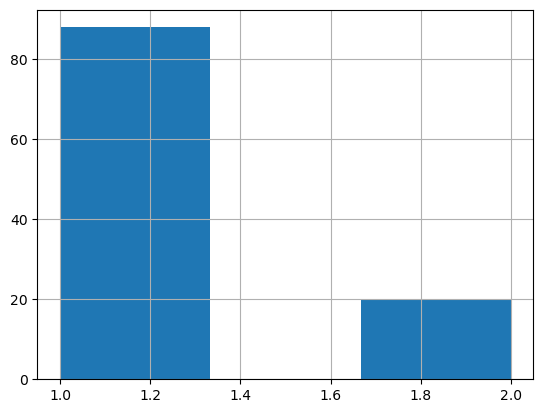

In [34]:
data1[data1["cat_id"]==0][data1["p123"]>0]["p123"].hist(bins=3)

In [35]:
data1[data1["cat_id"]==0][data1["p123"]==3]
#В тройках расхождений нет.

/tmp/ipykernel_58783/2246431814.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==3]


,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123


In [36]:
data1[data1["cat_id"]==0][data1["p123"]==2]
#В двойках расхождения есть - 15. Но, на первый взгляд, это скорее ошибки разметки.

/tmp/ipykernel_58783/2162960197.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==2]


,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
44233,7f8b6c934818404a3d6fafa9124af785,0,Булгаков М. Собачье сердце. Мр3 Вимбо,12335 12336 594 6 8 597 2952,Вимбо,---,4602074400906,---,---,---,...,Вимбо,---,1,1,0,0.906617,0.964355,0.005838,2,1.876810
61994,0fe05aa193e44f8d9e623245782274f0,0,Девичник в Вегасе,1303 2585 6 12335 594 8 604 12336 49,Universal Studios,США,4690446005798,---,---,---,...,---,---,1,1,0,0.724474,0.511920,0.001132,2,1.237526
87184,760503baa0c1d13fe99e8c7b3cf07630,0,"Гарик Сукачёв (Неприкасаемые, Бригада С) - Вне...",12335 56 6 8 61 594 598 604 12336,Медиа,---,4690251016330,черный,1 LP,---,...,---,---,1,1,0,0.824349,0.748356,0.023107,2,1.595812
102782,8e2410b4df777f4a55194bfe531edfe5,0,LFO - Peel Session TX 20/10/90 (EP) Warp (307626),598 12335 6 49 2952 8 604 594,Plastinka.com,Евросоюз,110105337113,---,---,---,...,Warp,---,1,1,0,0.824349,0.940637,0.104084,2,1.869070
128492,3b89978022c8a50709dda88220d5b727,0,INTRA SPELAEUM - Мне Имя - Власть,2952 12336 8 597 594 6 12335,Медиа,---,4620005294486,---,---,---,...,Soundage Productions,---,1,1,0,0.906617,0.928134,0.092660,2,1.927410
138229,ed710c5f44fe0888d0c94330c72b7e89,0,Лицей Мчится Время,597 8 49 594 2952 6 12335 12336,Медиа,Россия,4620032912131,---,---,---,...,Мистерия Звука,---,1,1,0,0.857101,0.961204,0.005028,2,1.823333
185250,a0ee9e6696e6982335bcd6d5ef552e2a,0,Любовь с акцентом,12335 12336 8 594 1303 604 6 49,Медиа,США,4690241102142,---,---,---,...,---,---,1,1,0,0.724474,0.578015,0.000756,2,1.303245
222147,ce8b0c88eda0103e750b073fb7cb03b8,0,LTJ X-PERIENCE Deepening Of A Groove,6 49 598 604 8 594 2952 12335 12336 2955 56,NoBrand,Италия,8056234428648,---,Deepening Of A Groove,---,...,Irma,альбом,1,1,0,0.771692,0.852324,0.026027,2,1.650042
225212,9edada0e427c744b0f64c6e1eb256758,0,Midori Takada Tree Of Life (Half Speed),604 594 12335 12336 2952 8 6 56 598,NoBrand,---,4251804127387,---,Tree Of Life (Half Speed),---,...,WRWTFWW Records,---,1,1,0,0.824349,0.915759,0.093542,2,1.833650
261003,0e2ddf9d736c56758e7e5c5038213291,0,Драгунская К. Когда я была маленькая. Исп. авт...,6 56 594 597 8 12335 2952 12336,Вимбо,---,4602074400876,---,1 CD,---,...,Вимбо,---,1,1,0,0.857101,0.928202,0.005028,2,1.790332


In [37]:
data1[data1["cat_id"]==0][data1["p123"]==1]
#

/tmp/ipykernel_58783/2493237518.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==1]


,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
12701,a70fb8161ed1aed324bc6143c02a6889,0,Mike Stobbie - Дза Дзен / ZAZEN,6 56 8 12335 12336,Правительство Звука,---,4640001320347,---,CD,---,...,---,---,0,1,0,0.034607,0.923863,0.464053,1,1.422523
39067,8cae7242cefb0d92cb8252f8c67862cf,0,Кошелек Loungefly Star Wars: Episode IX The Ri...,8 12336 2035 56 12335 61 96 6,Loungefly,---,0671803301146,черный; красный,STWA0117,---,...,---,---,0,0,1,0.034607,0.002008,0.513159,1,0.549773
40909,b193a80b9463bf01731420996a1b5aa1,0,Дюна 2 (Dune II: The Battle For Arrakis) Русск...,598 2952 504 594 2648 12335 12336 12711 10630 ...,Медиа,---,---,---,---,---,...,Virgin,---,0,0,1,0.035117,0.027383,0.544426,1,0.606926
48291,ffcbd09e86cdc7d333a1176702cd3ffa,0,Гонки Под Рок-Н-Ролл Апгрейд (Rock N’ Roll Rac...,12335 8 12336,Медиа,---,---,---,---,---,...,---,---,0,1,0,0.034607,0.611314,0.004398,1,0.650318
49070,73a8cd534daa4dd78a5d35977ff73794,0,Кружка Pyramid Batman: The Batman Who Laughs: ...,12336 61 56 6 8 12368 96 2035 2 12335,PYRAMID,---,5050574254106,разноцветный,MGC25410,---,...,---,---,0,0,1,0.034607,0.001588,0.841745,1,0.877940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585188,a8cfd3f2e0209a61ab5ee428fce05e1c,0,Cyanide and Happiness: Freakpocalypse - Episod...,2955 2648 12336 10630 598 12676 6 12711 594 29...,Serenity Forge,---,819976027665,---,Cyanide and Happiness: Freakpocalypse,---,...,Serenity Forge,стандартное,0,0,1,0.043705,0.015343,0.887623,1,0.946671
598214,ce9417406e0923578812587caab0820c,0,Аксессуар Держатель для виниловых пластинок белый,96 4654 12336 12335 6 8 61,Мистерия Звука,---,9003829971590,белый,---,---,...,---,---,0,1,0,0.034607,0.611314,0.000169,1,0.646090
598838,3a0e49db9946939759c0fdd0d86c613d,0,Аккумулятор для наушников JBL Synchros E50BT (...,6 10029 12338 473 12336 56 8 597 12335,Cameron Sino,---,110095995683,---,P433638,---,...,---,---,1,0,0,0.618975,0.001588,0.000169,1,0.620733
600858,72efb84b89048d0a1fafc1ca799e3a5d,0,Игра The Legend of Heroes: Trails of Cold Stee...,2648 12711 2955 12676 6 2952 594 598 12336 123...,Медиа,---,810023035084,стальной,The Legend of Heroes: Trails of Cold Steel 3,---,...,NIS America,стандартное,0,0,1,0.043705,0.030976,0.604874,1,0.679555


In [38]:
data1[data1["p123"]==1]

,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
133,d2be1dd68e063eb014884f64ce0d5f6c,1,"Cordes, Marcel - Arien, Duette und Szenen -Moz...",6 8 56 12335 12336,Preiser Records,---,0717281934640,---,1 CD,---,...,---,---,0,1,0,0.034607,0.868688,0.464053,1,1.367348
4631,00799b32551c70f31b00dad21cb6014a,1,George Crumb : Une Petite Suite pour No;l - Ri...,8 56 6 12336 12335,Bridge,---,0090404900327,---,1 CD,---,...,---,---,0,1,0,0.034607,0.868688,0.362102,1,1.265397
5327,6206d9e679db3387cff3eec01e40fdc1,1,"MASCAGNI Cavalleria Rusticana. Varnay, Hopf, P...",6 8 56 12335 12336,Myto Classics,---,8014399500869,---,1 CD,---,...,---,---,0,1,0,0.034607,0.868688,0.023107,1,0.926403
8707,c8096e9e8854805a18fd805c5922a512,1,Theodorakis: Axion Esti; Canto General; Liturg...,12336 6 56 12335 8,Berlin Classics,---,0782124028022,---,6 CD,---,...,---,---,0,1,0,0.034607,0.923863,0.004398,1,0.962868
9175,83983e87f839a72671aca89c04caa6be,1,Гиляровский В.А. Москва и москвичи.Текст читае...,56 8 6 12335 12336,Медиа,---,4601546029065,---,2 mp3,---,...,---,---,0,1,0,0.034607,0.846533,0.001514,1,0.882654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602342,ffc6b821fe2ee41503a55a2e6dd444a6,1,Борис Гребенщиков и Майк Науменко - Все Братья...,61 12336 12335 56 8 6,Мирумир,---,0889397102937,черный,1 LP,---,...,---,---,0,1,0,0.034607,0.868688,0.003147,1,0.906442
602728,33825d6782a69097c41376d871ffeb3d,1,"Сборник """"Музыка Павловского вокзала: Глинка, ...",8 56 12335 12336 6,Bomba-Piter,---,4607053321760,---,1 CD,---,...,---,---,0,1,0,0.034607,0.868688,0.005838,1,0.909133
603966,7b6aa537086b67b4e16cfd6f5945a35d,0,MENDEZ Adrenaline,12336 56 12335 6 8,Медиа,---,0044001735394,---,CD,---,...,---,---,0,1,0,0.034607,0.846533,0.004398,1,0.885537
604563,00b0ee4760d47898883d25569d9b9cd4,1,Виниловая пластинка Padang Moonrise (The Birth...,12335 56 8,Soundway,---,---,---,Various Artists Padang Moonrise (The Birth Of ...,---,...,---,---,0,0,1,0.034607,0.002008,0.916147,1,0.952762


In [39]:
data1[data1["cat_id"]==1][data1["p123"]==0]
#Ошибки второго рода. потери - 64.

/tmp/ipykernel_58783/3590919184.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==1][data1["p123"]==0]


,hash_id,cat_id,source_name,attr_id,8,49,6,61,56,5,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
376,918aa7de2390e525fe6fb27df648ac16,1,"Louis Armstrong ?The Okeh, Columbia & RCA Vict...",12335 6 8 594 12336 2952,Медиа,---,888430658622,---,---,---,...,Sony Music,---,0,0,0,0.228135,0.250290,0.207599,0,0.686024
10053,129b6864179d2ac9897aa74a792f55c8,1,Whitesnake: Box'O'Snakes: Sunburst Years 1978-...,12336 56 12335 6 8,EMI Records,---,5099967954223,---,11 (9 CD + 1 DVD + 1 LP),---,...,---,---,0,0,0,0.034607,0.002008,0.099468,0,0.136083
13516,9f8efeda5c2ed5e0bb55e7464a9c4c91,1,Talking Heads Stop Making Sense (Music From A ...,6 12335 8 56,Warner,---,603497824007,---,Talking Heads Stop Making Sense (Music From A ...,---,...,---,---,0,0,0,0.034607,0.002008,0.334970,0,0.371584
17318,a5a436662d17476faf8e9d3236ca63f7,1,Nino Ferrer ?– L'Integrale - coffret (inclus b...,56 6 12336 12335 8,Barclay,---,0602498210918,---,13 (12 CD + 1 DVD),---,...,---,---,0,0,0,0.034607,0.002008,0.362102,0,0.398717
39698,369d376b3a7777bf1755d2270a4e8dce,1,JOHNNY CASH / WILLIE NELSON / WAYLON JENNINGS ...,6 8 12336 12335,NoBrand,---,8719262003743,---,---,---,...,---,---,0,0,0,0.034607,0.001588,0.100553,0,0.136748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549622,252b0390f8ed6e144401193eedf3a4bf,1,Андрей Макаревич И Оркестр Креольского Танго ?...,594 8 12343 6 12336 12344 2952 49 12335,Медиа,Россия,4607097190285,---,---,---,...,Sintez Records,---,0,0,0,0.095082,0.250290,0.334970,0,0.680342
550509,49a934dc3b798a14c91cdb927fdf72af,1,"JANOS STARKER, GYORGY SEBOK Bartok / Mendelsso...",8 12335 6 56,"JANOS STARKER, GYORGY SEBOK",---,8808678161878,---,Bartok / Mendelssohn / Martinu / Debussy / Cho...,---,...,---,---,0,0,0,0.034607,0.002008,0.003105,0,0.039720
569004,15f7a2accec4d2ec034ffb44491f9818,1,"Killing Joke Xxv Gathering: Let Us Prey (2LP),...",6 8 61 12335 56,Cooking Vinyl,---,0711297475807,желтый,Xxv Gathering: Let Us Prey,---,...,---,---,0,0,0,0.034607,0.002008,0.038983,0,0.075598
572028,d91a654bfdf3839a5f5f20ddeb640f75,1,Старые добрые сказки. Чарская Л. Шарль Перро. ...,6 56 12335 8 12336,Твик-Лирек,---,4615254643383,---,CD-MP3,---,...,---,---,0,0,0,0.034607,0.002008,0.004398,0,0.041012


## Применение на unlabeled

In [40]:
%%time
pl.Config.set_tbl_rows(6)
unlabeled=pl.read_parquet("unlabeled_train.parquet")#.with_columns(pl.col("cat_id").cast(pl.Int16))
unlabeled

unlabeled1 = unlabeled.with_columns((pl.col("attributes").str.slice(3,pl.col("attributes").str.len_chars()-5)
                               ).str.split("},{") )
unlabeled1


unlabeled1 = unlabeled1.explode("attributes"
                         ).with_columns(
    pl.col("attributes").str.extract(r"\"attribute_id\"\"\:(\d+?),", 1).cast(pl.Int16).alias("attr_id"),
    pl.col("attributes").str.extract(r"\"\"attribute_name\"\":\"\"(.+?)\"\"", 1).alias("attr_name"),
    pl.col("attributes").str.extract(r"\"\"attribute_value\"\":\"\"(.+?)\"\"", 1).alias("attr_value"),
    pl.col("attributes").str.extract(r"\"\"attribute_measure\"\":\"\"(.+?)\"\"", 1).alias("attr_measure"),
)
unlabeled1

dataun=unlabeled1.with_columns( pl.col("attr_id").cast(pl.String)
                     ).group_by("hash_id",
                                #"cat_id",
                                "source_name"
                 ).agg(pl.col("attr_id").unique()
                      ).with_columns( pl.col("attr_id").list.join(separator=" ")
                                    ).join(
    unlabeled1.filter(pl.col("attr_id").is_in(idatrlist460)
                           ).pivot("attr_id", index="hash_id", values="attr_value", aggregate_function="first"
                                  ),
    how="left",
    on="hash_id"
)
dataun

CPU times: user 28 s, sys: 3.12 s, total: 31.2 s
Wall time: 13.9 s


hash_id,source_name,attr_id,8,61,6,56,49,5,594,597,598,604,2952,2955
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""9bdd74c29846f34e45e58c87d612668c""","""Модуль 2-х осевого джойстика KY-023 для Arduino""","""""",null,null,null,null,null,null,null,null,null,null,null,null
"""fdf9d74140ec0d74e87da0992b578853""","""Накладка на стик KontrolFreek Call of Duty Moder для геймпада Playstation 4/5, 2 шт""","""56 97 10029 12335 13602 6 8""","""KontrolFreek""",null,"""810052984025""","""Call of Duty Moder""",null,null,null,null,null,null,null,null
"""b905455127faf807a13ad00c453a9552""","""Беспроводная мышь A4Tech Fstyler FG10S Black/Blue""","""""",null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""605cd7a64d6bd071481f3b128528cb75""","""Чайник электрический Goodhelper A07 1.8 л Серебристый""","""8 56 96 204 12335 13580 61 6 12342""","""Goodhelper""","""Серебристый""","""6900103680083""","""A07""",null,null,null,null,null,null,null,null
"""a3471738ec3ae88064b5620cade5a14b""","""Кофемолка электрическая""","""11740 12405 11742 12411 12407 8 482 12406 49 45 12335 14 52 15""","""DEXP""",null,null,null,"""Китай""",null,null,null,null,null,null,null
"""b703a7f1b7160d48c5b9ef194fd50e07""","""Кастрюля Master House Signore-6,7 со стеклянной крышкой""","""13 45 55 2036 2037 2045 135 2034 6 2948 79 1092 2035 15 1977 1979 12335 49 3112 1978 14 56 2042 2""",null,null,"""4627108606048""","""Signore-6,7 со стеклянной крышкой""","""Китай""",null,null,null,null,null,null,null


In [41]:
dataun0 = dataun.filter(pl.col("attr_id")!=""  #TD для товаров без атрибутов нужна будет отдельная доработка
                  #).with_columns(pl.col("cat_id")==460
                  #).with_columns(pl.col("cat_id").cast(pl.Int8)
                                ).fill_null("---")
dataun0

dataun1 = dataun0.to_pandas()
dataun1

,hash_id,source_name,attr_id,8,61,6,56,49,5,594,597,598,604,2952,2955
0,fdf9d74140ec0d74e87da0992b578853,Накладка на стик KontrolFreek Call of Duty Mod...,56 97 10029 12335 13602 6 8,KontrolFreek,---,810052984025,Call of Duty Moder,---,---,---,---,---,---,---,---
1,346752c36d794f6f91b117be6cf66e33,Виниловая пластинка Various Artists The Univer...,598 2952 8 6 604 12336 594 49 12335,Мистерия Звука,---,3596974230767,---,Евросоюз,---,Folk,---,LP,2022,Play It Again Sam,---
2,164ba20b7b808aba19c31764c0626919,Наушники проводные игровые большие с микрофоно...,8 15 11742 12335 45 49 52 12405 14 482 12406 1...,Ritmix,---,---,---,Китай,---,---,---,---,---,---,---
3,976b81cec7e854310482324bd67db3e7,Набор винтов для iPhone 11 Pro (внутренние),12405 12406 12407 12411 8 49 15 11742 52 11740...,Нет бренда,---,---,---,Китай,---,---,---,---,---,---,---
4,11ef077e4580806f7dce0c782c59a987,Чехол для стоек Manfrotto MB LBAG110,12335 12336 8,Manfrotto,---,---,---,---,---,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685714,5cbbc6a9e02acdc5b3b77c13aeba043a,Электрическая плита Gorenje GEC5C42WG белый,10029 1096 6316 12338 56 61 12344 12349 12350 ...,Gorenje,белый,---,GEC5C42WG,---,---,---,---,---,---,---,---
685715,5a40182995fa03f8c1d38f236e0b8c93,Чехол-кобура MyPads Сintura для iOcean X7S-T с...,12335 61 56 12338 8 12340 96 10029 1669,MyPads,черный,---,Сintura,---,---,---,---,---,---,---,---
685716,605cd7a64d6bd071481f3b128528cb75,Чайник электрический Goodhelper A07 1.8 л Сере...,8 56 96 204 12335 13580 61 6 12342,Goodhelper,Серебристый,6900103680083,A07,---,---,---,---,---,---,---,---
685717,a3471738ec3ae88064b5620cade5a14b,Кофемолка электрическая,11740 12405 11742 12411 12407 8 482 12406 49 4...,DEXP,---,---,---,Китай,---,---,---,---,---,---,---


In [42]:
dataun1["p1"]=cb1.predict(dataun1[cols1])
dataun1["p2"]=cb2.predict(dataun1[cols2])
dataun1["p3"]=cb3.predict(dataun1[cols3])

dataun1["p_1"]=cb1.predict_proba(dataun1[cols1])[:,1]
dataun1["p_2"]=cb2.predict_proba(dataun1[cols2])[:,1]
dataun1["p_3"]=cb3.predict_proba(dataun1[cols3])[:,1]

dataun1["p123"]=dataun1["p1"]+dataun1["p2"]+dataun1["p3"]
dataun1["p_123"]=dataun1["p_1"]+dataun1["p_2"]+dataun1["p_3"]
dataun1[dataun1["p123"]==3]

,hash_id,source_name,attr_id,8,61,6,56,49,5,594,...,2952,2955,p1,p2,p3,p_1,p_2,p_3,p123,p_123
1,346752c36d794f6f91b117be6cf66e33,Виниловая пластинка Various Artists The Univer...,598 2952 8 6 604 12336 594 49 12335,Мистерия Звука,---,3596974230767,---,Евросоюз,---,Folk,...,Play It Again Sam,---,1,1,1,0.824349,0.948267,0.916147,3,2.688763
12,5c7904f50a28cc1bd92aaa5f35553aff,E-17: Resurrection (1 CD),12335 597 6 12336 49 8 594,Медиа,---,5014469530157,---,Евросоюз,---,Hip-Hop,...,---,---,1,1,1,0.857101,0.986719,0.924899,3,2.768719
48,f94178d01c3def64c236fbe68d80c3d9,Santana - Definitive Collection (1 CD),49 597 12336 6 12335 8 594,Медиа,---,5099747264153,---,Евросоюз,---,Rock; Latin; Blues; Pop,...,---,---,1,1,1,0.857101,0.986719,0.969243,3,2.813063
88,053d60ed684e5ae2c614c51955266e7c,Rolling Stones - Sticky Fingers (1 CD),8 597 594 12335 49 12336 6,Медиа,---,0602527015620,---,Евросоюз,---,Rock,...,---,---,1,1,1,0.906617,0.988331,0.944408,3,2.839356
110,05f053e81271d00a5ef0a6426da4808d,Akurat: Czlowiek (1 CD),597 12335 12336 8 49 594 6,Медиа,---,5903427872579,---,Евросоюз,---,Rock,...,---,---,1,1,1,0.857101,0.988331,0.924899,3,2.770331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685445,b126f320812c93017d0b2680a0978f99,"Public Image Limited The Greatest Hits, So Far...",598 594 597 49 604 12335 2955 2952 12336 6 8,Virgin,---,0600753510926,---,Евросоюз,---,Alternative; Rock,...,Virgin,переиздание,1,1,1,0.817275,0.953549,0.841745,3,2.612569
685485,030275236fb70610683db9017ae22875,Various Artists: The Cruisin' Story 1955 (2 CD),12335 12336 49 6 594 597 8,Медиа,---,5060255181676,---,Евросоюз,---,Rock; Funk; Soul,...,---,---,1,1,1,0.857101,0.986719,0.975395,3,2.819215
685537,ed47720c275c5fe77d528190b6e51712,Marc Moulin: Sam's Suffy (1 CD),49 6 8 594 597 12335 12336,Медиа,---,0724356367609,---,Евросоюз,---,Jazz; Funk; Soul,...,---,---,1,1,1,0.857101,0.986719,0.924899,3,2.768719
685547,db1dabb6719e4c95accbda30c7a7a70c,The Republic Of Mars The Beast From The East (CD),8 49 594 12336 2952 597 12335,Irond,---,---,---,Россия,---,Hard Rock; Rock,...,Irond; Molot Records,---,1,1,1,0.857101,0.886622,0.916147,3,2.659871


In [43]:
idcat=460
ids = dataun1[dataun1["p123"]==3]["hash_id"].unique()
dop = unlabeled.filter(pl.col("hash_id").is_in(ids)
                      ).with_columns(cat_id = pl.lit(idcat)
                                    )
dop.write_parquet(f"dop{idcat}_3of3_{dop.shape[0]}.parquet")
dop

hash_id,source_name,attributes,cat_id
str,str,str,i32
"""00014871748a675578a01dbbdff4fb76""","""Rahul Sharma: Music of the Himalayas (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0724381262122""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""0002b8838656bf30050d30979f65e933""","""Fred McDowell - Long Way From Home (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0025218053525""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""000718c1882f72070aebce358406f303""","""Big Brother & Holding Company - Cheap Thrills (LP)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0886919479911""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
…,…,…,…
"""ffe8083c02df651ac418c06c49078ab7""","""Craze – FabricLive.38 (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0802560007624""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""ffeeda68612c60128f5d35b4b831687c""","""Orbit William The Painter (2Винил)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0190296278495""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fff92bcd8d50ba41098a7b158113ce28""","""BOOTSY COLLINS - Tha Funk Capital Of The World (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""8712725731023""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460


In [44]:
ids = dataun1[dataun1["p123"]>=2]["hash_id"].unique()
dop = unlabeled.filter(pl.col("hash_id").is_in(ids)
                      ).with_columns(cat_id = pl.lit(idcat)
                                    )
dop.write_parquet(f"dop{idcat}_23of3_{dop.shape[0]}.parquet")
dop

hash_id,source_name,attributes,cat_id
str,str,str,i32
"""00014871748a675578a01dbbdff4fb76""","""Rahul Sharma: Music of the Himalayas (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0724381262122""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""0002b8838656bf30050d30979f65e933""","""Fred McDowell - Long Way From Home (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0025218053525""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""00043e20ae0c922a0bd665a1448bed8b""","""Vampire Rex (LP)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""194397363814""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attr…",460
…,…,…,…
"""fff57b727b11033b332a3a1a3795e44a""","""Vader / Impressions In Blood (RU)(CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4607138051650""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fff92bcd8d50ba41098a7b158113ce28""","""BOOTSY COLLINS - Tha Funk Capital Of The World (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""8712725731023""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fffe09fe4e0d36cbdf2ca9eaf45fb760""","""Joe Bonamassa The Ballad Of John Henry (Brown) (2Винил)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0810020507119""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460


In [45]:
ids = dataun1[dataun1["p123"]>=1]["hash_id"].unique()
dop = unlabeled.filter(pl.col("hash_id").is_in(ids)
                      ).with_columns(cat_id = pl.lit(idcat)
                                    )
dop.write_parquet(f"dop{idcat}_123of3_{dop.shape[0]}.parquet")
dop

hash_id,source_name,attributes,cat_id
str,str,str,i32
"""00014871748a675578a01dbbdff4fb76""","""Rahul Sharma: Music of the Himalayas (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0724381262122""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""0002b8838656bf30050d30979f65e933""","""Fred McDowell - Long Way From Home (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0025218053525""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""00043e20ae0c922a0bd665a1448bed8b""","""Vampire Rex (LP)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""194397363814""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attr…",460
…,…,…,…
"""fff92bcd8d50ba41098a7b158113ce28""","""BOOTSY COLLINS - Tha Funk Capital Of The World (1 CD)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""8712725731023""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fffdd4b822b46405029914e76f192ba3""","""Serguei: L'homme Nu""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0826596075860""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fffe09fe4e0d36cbdf2ca9eaf45fb760""","""Joe Bonamassa The Ballad Of John Henry (Brown) (2Винил)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0810020507119""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460


In [46]:
ids = dataun1[dataun1["p123"]==1]["hash_id"].unique()
dop = unlabeled.filter(pl.col("hash_id").is_in(ids)
                      ).with_columns(cat_id = pl.lit(idcat)
                                    )
dop

hash_id,source_name,attributes,cat_id
str,str,str,i32
"""0005c9fbb52228ce64a89171cc66cd95""","""VARIOUS ARTISTS: Carnival Northern Soul (cd)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0029667232722""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""001004779d1452ed973fbcf37120ecfa""","""Mark Wirtz Ear Theat: Love Is Eggshaped (cd)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4540399021140""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""0012a750ffc794aadd96ec6b8c82e512""","""Whole Wheat Bread: Minority Rules (cd)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0008817036328""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
…,…,…,…
"""fff495c360d3041a41d844555cc925d0""","""Joshua Redman Where Are We (2LP)""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""602455253019""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attr…",460
"""fff8fa94209dfd712f226fc312a8d7ae""","""Чайковский: Серенада до мажор, Соната №3 – Кондрашин""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4607167793347""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460
"""fffdd4b822b46405029914e76f192ba3""","""Serguei: L'homme Nu""","""[{""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""0826596075860""""},{""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""att…",460


In [ ]:
#Что дальше?
#А) Можно тюнить (повысить специализацию)
#Б) Можно применить на других категориях (повысить универсальность)